In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

In [2]:
# === 1. Data Preparation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=True,
    validation_split=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    channel_shift_range=20.0,
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 840 images belonging to 15 classes.
Found 210 images belonging to 15 classes.
Found 300 images belonging to 15 classes.


In [3]:
# === 2. Load Pretrained Base Model ===
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Unfreeze 20 layer terakhir
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# === 3. Tambahkan Custom Classifier ===
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

2025-04-24 14:18:07.023637: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-24 14:18:07.023964: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-24 14:18:07.023968: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1745479087.024328 6737412 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745479087.025234 6737412 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# === 4. Compile Model ===
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# === 5. Train Model ===
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=35,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    ]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35


2025-04-24 14:18:10.518420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.0842 - loss: 3.6751 - val_accuracy: 0.1190 - val_loss: 2.9722
Epoch 2/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 657ms/step - accuracy: 0.1976 - loss: 2.8879 - val_accuracy: 0.1952 - val_loss: 2.6151
Epoch 3/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 565ms/step - accuracy: 0.3195 - loss: 2.3115 - val_accuracy: 0.2524 - val_loss: 2.3830
Epoch 4/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 609ms/step - accuracy: 0.4596 - loss: 1.8887 - val_accuracy: 0.3095 - val_loss: 2.3951
Epoch 5/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step - accuracy: 0.4532 - loss: 1.7266 - val_accuracy: 0.3762 - val_loss: 2.1534
Epoch 6/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 566ms/step - accuracy: 0.5126 - loss: 1.5142 - val_accuracy: 0.4000 - val_loss: 2.1397
Epoch 7/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 612ms/step - accuracy: 0.5551 - loss: 1.4160 - val_accuracy: 0.4143 - val_loss: 2.0909
Epoch 8/35
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - accuracy: 0.6034 - loss: 1.2405 - val_accuracy: 0.4333 - val_l

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.5792 - loss: 1.8569
Akurasi di data test: 63.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 865ms/step


<Figure size 1000x1000 with 0 Axes>

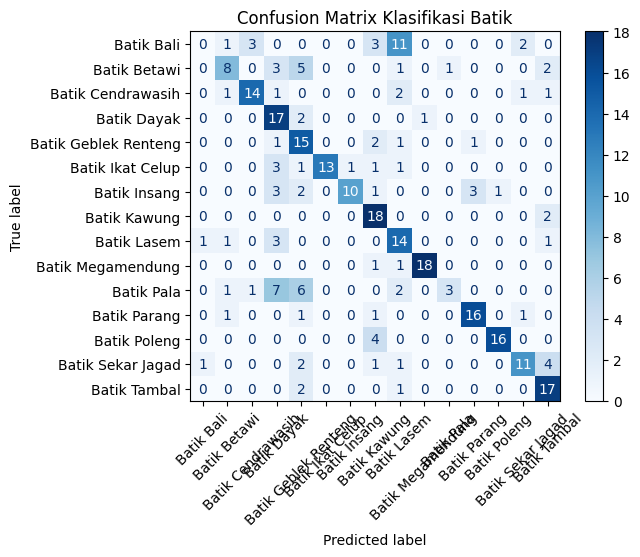

In [6]:
# === 6. Evaluate Model ===
loss, accuracy = model.evaluate(test_generator)

print(f"Akurasi di data test: {accuracy*100:.2f}%")

# === 7. Confusion Matrix ===
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Klasifikasi Batik")
plt.show()

In [7]:
from datetime import datetime

# === 10. Save Log to File ===
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Cek tren naik/turun
def trend(metric):
    return "naik" if metric[-1] > metric[0] else "turun"

# Overfitting check
overfitting = (val_acc[-1] - accuracy) > 0.1

# Catatan manual. 
note = "label smoothing: delete; ReduceLROnPlateau: delete; gaussian blur"

# Timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Tulis log
log_line = (
    f"{timestamp}\n"
    f"akurasi: {accuracy*100:.2f}%\n"
    f"overfitting: {overfitting}\n"
    f"accuracy: {trend(train_acc)}\n"
    f"loss: {trend(train_loss)}\n"
    f"val_accuracy: {trend(val_acc)}\n"
    f"val_loss: {trend(val_loss)}\n"
    f"perubahan: {note}\n"
    f"---\n\n"
)

In [8]:
# Hitung benar per kelas
correct_per_class = np.diag(cm)
class_info = []

for label, correct_count in zip(class_labels, correct_per_class):
    if correct_count >= 15:
        class_info.append(f"{label}: {correct_count} benar")

# Tambahkan ke log
if class_info:
    log_line += "kelas dengan ≥15 benar:\n"
    log_line += "\n".join(class_info) + "\n"
    log_line += "---\n\n"

# Simpan ke file
with open("hasil_log.txt", "a") as f:
    f.write(log_line)

In [9]:
model.save("model_batik.h5")